In [576]:
import numpy as np
import pandas as pd
from scipy.sparse import random as sparse_random
from scipy.sparse.linalg import norm
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown
np.random.seed(70) #for reproducibility

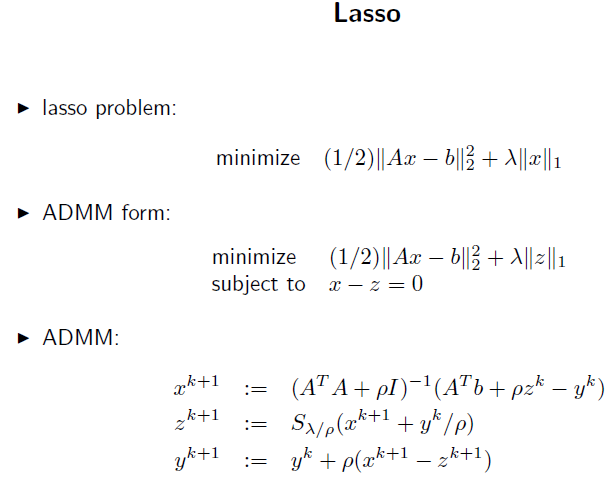

**Lasso Problem:**
$ \frac{1}{2} \| \mathbf{A}\mathbf{x} - \mathbf{b} \|_2^2 + \lambda \| \mathbf{x} \|_1$

**ADMM standard format:**   
Minimize:
$ f(x) + g(x)$

Subject to:
$ Ax + Bz = c$


**Lasso Problem in ADMM format:**\
Minimize:\
$ \mathbf{ \frac{1}{2} \| Ax - b \|_2^2 + \lambda \| z \|_1 } $

Subject to:\
$ \mathbf{ x - z = 0 } $

**Where:**\
$ \mathbf{A} \in \mathbb{R}^{Nb \times Nx} $ \
$ \mathbf{x} \in \mathbb{R}^{Nx} $ \
$ \mathbf{b} \in \mathbb{R}^{Nb} $ \
$ \mathbf{z} \in \mathbb{R}^{Nx} $

**INITIALIZE VARIABLES**

In [577]:
Nb = 1200 # Size of vector b (m)
Nx = 1200 # Size of vector x (n)

# np.random.randn generates random numbers from a standard normal distribution (mean = 0, std = 1)
A = np.random.randn(Nb, Nx)
true_coeffs = np.random.randn(Nx)
b = A @ true_coeffs + np.random.randn(Nb) * 0.5
x_init = np.zeros(Nx)
z_init = np.zeros(Nx)

# y represents the lagrange multiplier and dual variable
y_init = np.zeros(Nx)

**INSPECT GENERATED VARIABLES**

Shape of A:  (1200, 1200)
Shape of b:  (1200,)


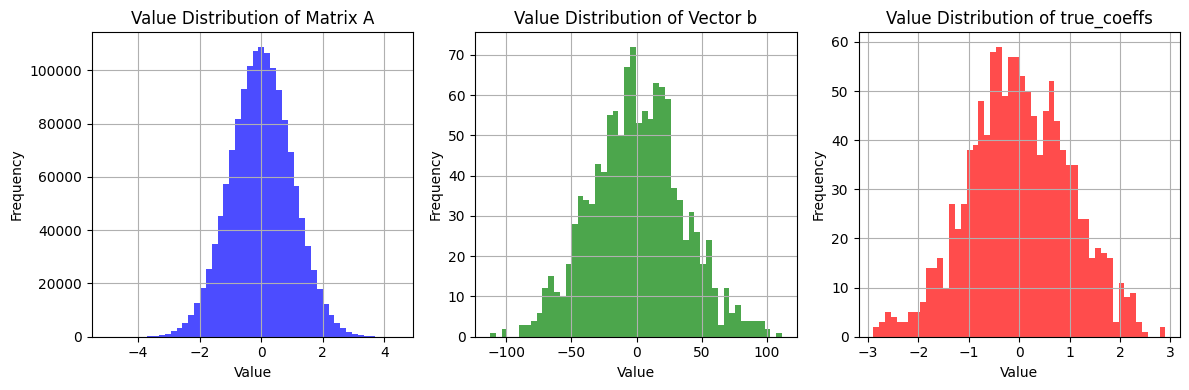

In [578]:
print("Shape of A: ", (A).shape)
print("Shape of b: ", (b).shape)

# Flatten the matrix A
values_A = A.flatten()

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))


# Plot histogram for matrix A
axs[0].hist(values_A, bins=50, color='blue', alpha=0.7)
axs[0].set_title('Value Distribution of Matrix A')
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')
axs[0].grid(True)

# Plot histogram for vector b
axs[1].hist(b, bins=50, color='green', alpha=0.7)
axs[1].set_title('Value Distribution of Vector b')
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')
axs[1].grid(True)

# Plot histogram for vector true_coeffs
axs[2].hist(true_coeffs, bins=50, color='red', alpha=0.7)
axs[2].set_title('Value Distribution of true_coeffs')
axs[2].set_xlabel('Value')
axs[2].set_ylabel('Frequency')
axs[2].grid(True)

# Show the plots
plt.tight_layout()  # Adjusts subplot params so that subplots fit into the figure area.
plt.show()

**ADMM LASSO FUNCTION**

In [579]:
def z_minimization_step(x, y, rho, lambd):
    tau = lambd / rho
    vector = x + y / rho
    # Apply soft-thresholding element-wise
    return np.sign(vector) * np.maximum(np.abs(vector) - tau, 0)

def ADMM_Lasso(x, z, y, rho, lambd, epsilon, max_iters):
    list_primal_res = []
    list_dual_res = []
    list_x = []
    list_z = []

    iters = np.arange(0, max_iters) # max number of iterations
    # (A.T * A + rho * I)^(-1)
    cached_inv = np.linalg.inv(np.matmul(A.T, A) + rho*np.identity(Nx)) # O(n^3)

    for k in iters:

        # primal variable updates
        x = np.matmul(cached_inv, np.matmul(A.T, b) + rho*z - y) # x-minimization step
        z_prev = z.copy() # Store the previous value of z for convergence checking
        z = z_minimization_step(x, y, rho, lambd) # z-minimization step

        # dual variable update
        y = y + rho * (x - z)

        # calculate residuals
        primal_res = np.linalg.norm(x - z, ord=2)
        dual_res = rho * np.linalg.norm(z - z_prev, ord=2)

        list_primal_res.append(primal_res)
        list_dual_res.append(dual_res)

        # Check for convergence
        if primal_res < epsilon and dual_res < epsilon:
            break
    
    return list_primal_res, list_dual_res, list_x, list_z

In [580]:
def plot_residuals(list_primal_res, list_dual_res, rho, lambd):
    plt.figure(figsize=(8,4))
    plt.plot(list_primal_res, label="Primal residual")
    plt.plot(list_dual_res, label="Dual residual")
    plt.yscale("log")
    plt.xlabel("Iterations")
    plt.ylabel("Residual Error")
    plt.title(f"ADMM Convergence Plot (rho={rho}, lambda={lambd})")
    plt.legend()
    plt.grid(which='both', axis='both')  # Enable grid for log scale
    plt.ylim(10**-18, 10**3)  # Limit the y-axis to this range.

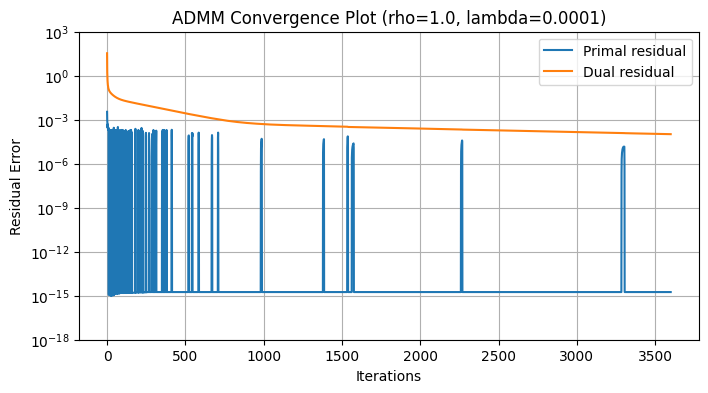

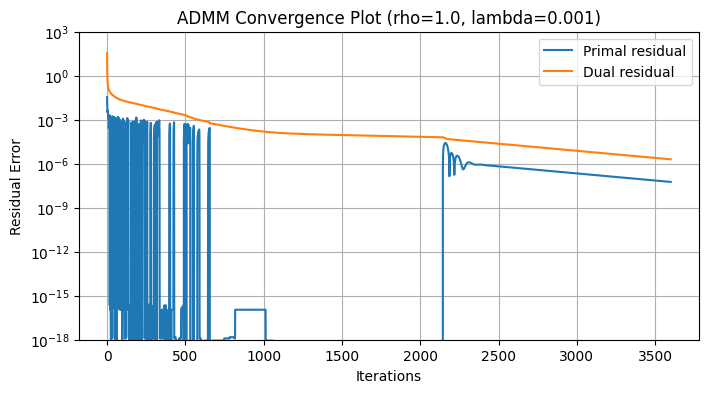

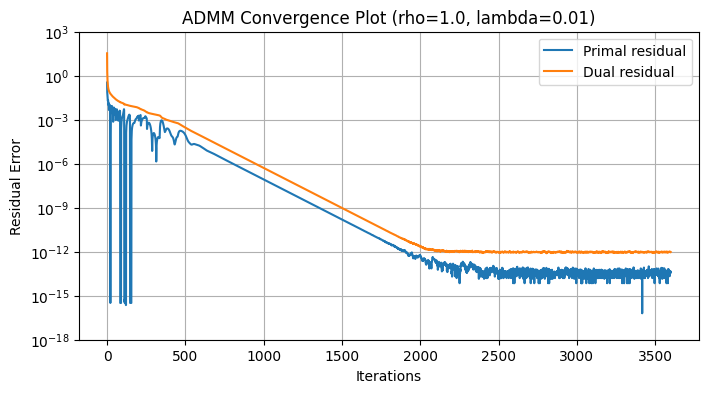

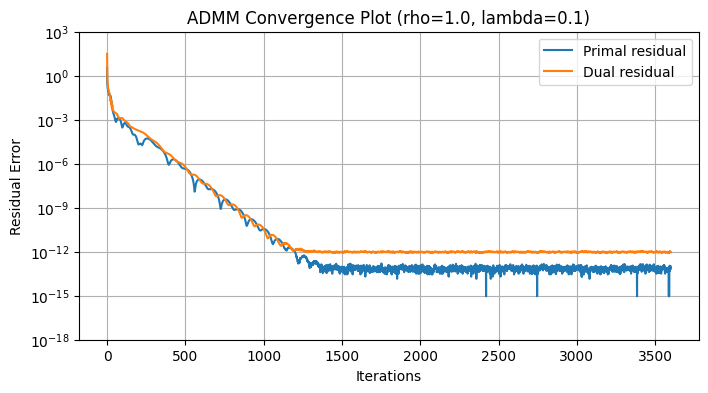

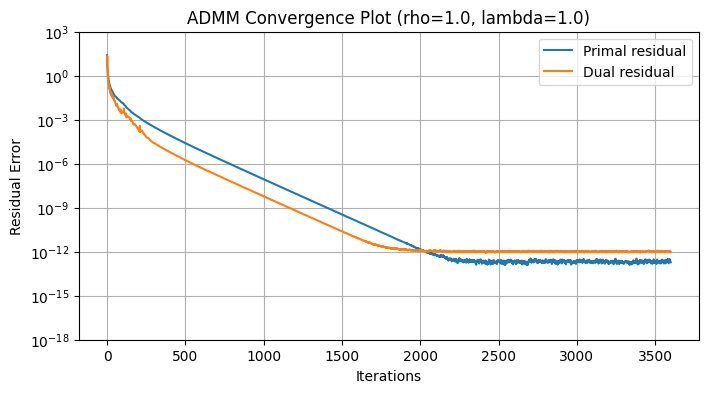

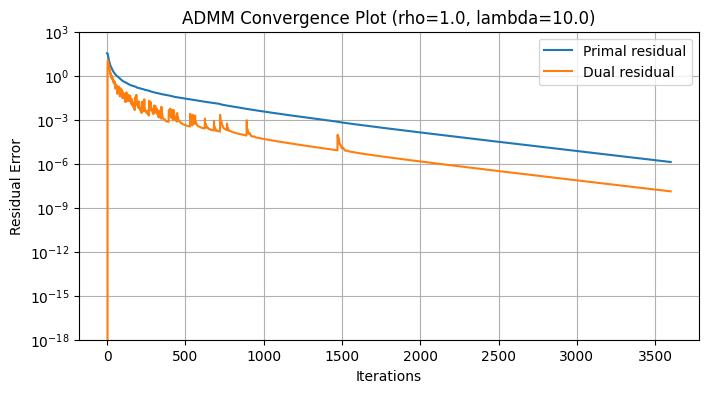

In [581]:
for i in range(6):
    # test lambdas from 0.0001 to 10.0
    lambd = 0.0001 * 10**i
    rho = 1.0
    list_primal_res, list_dual_res, list_x, list_z = ADMM_Lasso(x_init, z_init, y_init, rho=rho, lambd=lambd, epsilon=1e-13, max_iters=3600)
    plot_residuals(list_primal_res, list_dual_res, rho=rho, lambd=lambd)

An odd phenomenon sometimes happens in the first 200 iterations. There sometimes seems to be a false convergence in the Primal residual. This occurs during the calculation of the primal residual, which takes the norm of x and z. This implies that during these iterations, that x and z are very very close to eachother, so close that their difference approaches the precision limit. This might be a coincidence but could suggest a subtle bug in the ADMM Lasso function. That being said, this "false convergence" in the primal does not stop the algorithm because the convergence condition checks if BOTH the primal and dual residuals fall below epsilon. This false convergence seems to occur much less in the dual variable, but it is not clear why. If the tiny difference between primal variables x and z is a coincidence, then why don't we see it in the dual variable y at the same rate? With thousands of iterations you would expect something similar to happen with the dual variable y.

**FROM THESE PLOTS, IT APPEARS LAMBDA=0.1 WORKS WELL**

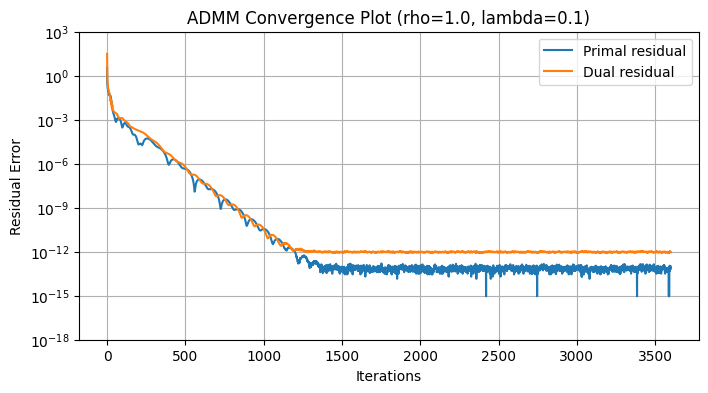

In [582]:
def single_test():
    lambd = 0.1
    rho = 1.0
    list_primal_res, list_dual_res, list_x, list_z = ADMM_Lasso(x_init, z_init, y_init, rho=rho, lambd=lambd, epsilon=1e-13, max_iters=3600)
    plot_residuals(list_primal_res, list_dual_res, rho=rho, lambd=lambd) # REMEMBER TO EDIT RHO AND LAMBDA ACCORDINGLY
single_test()

**WITH A FIXED LAMBDA=0.1, TEST DIFFERENT VALUES OF RHO**

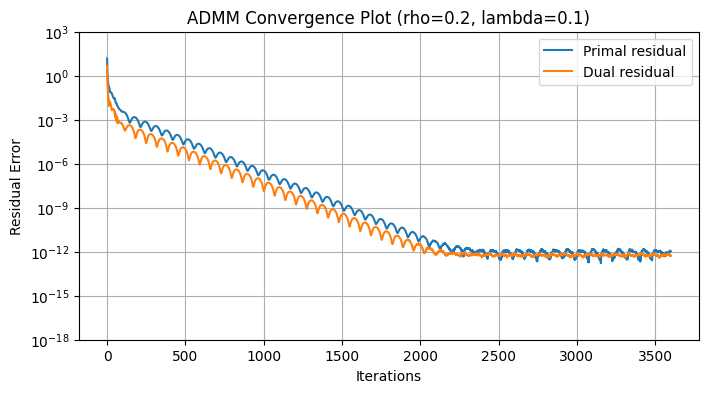

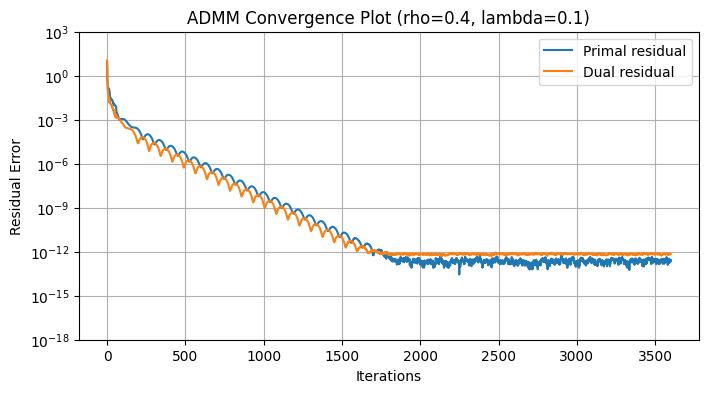

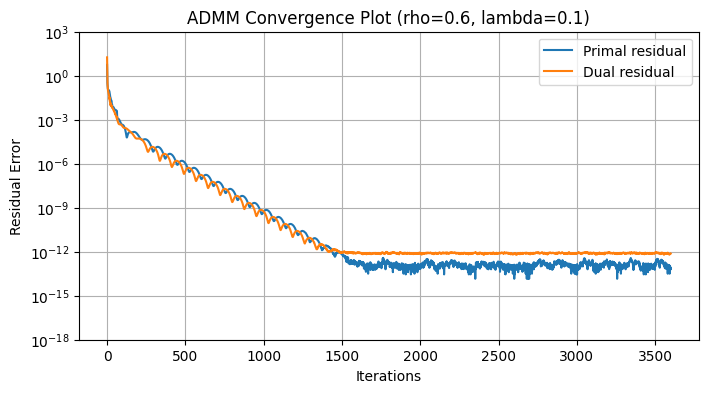

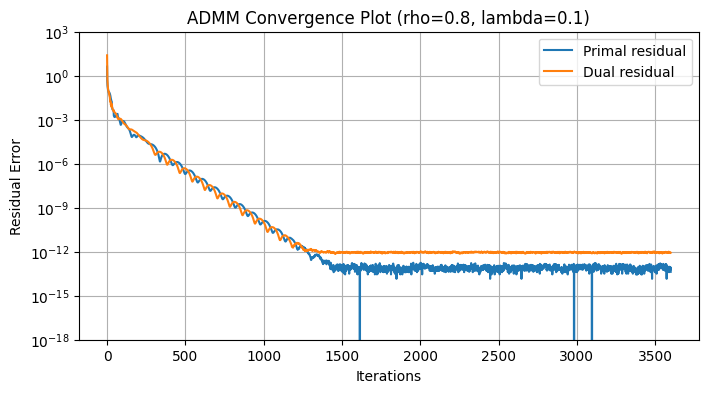

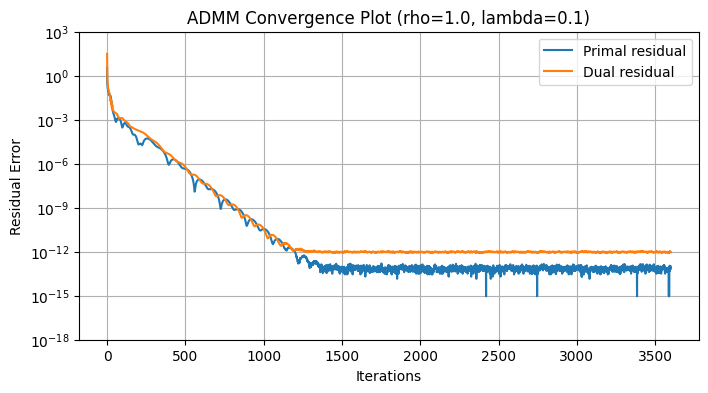

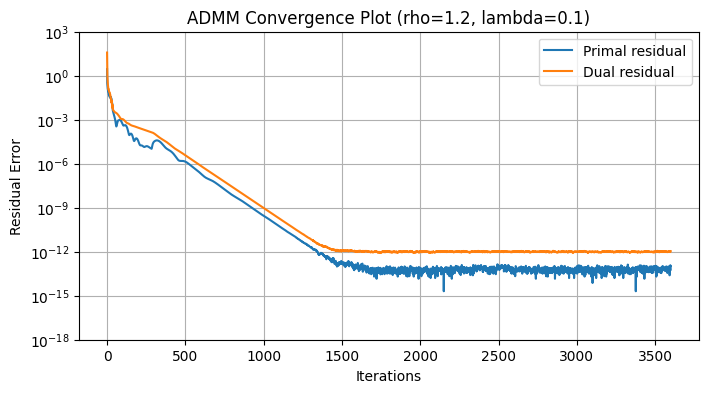

In [583]:
for i in range(6):
    # test different rhos
    lambd = 0.1 # fixed lambda
    rho = round(0.2 + 0.2 * i, 1)
    list_primal_res, list_dual_res, list_x, list_z = ADMM_Lasso(x_init, z_init, y_init, rho=rho, lambd=lambd, epsilon=1e-13, max_iters=3600)
    plot_residuals(list_primal_res, list_dual_res, rho=rho, lambd=lambd)

**IT APPEARS RHO=1.0 LAMBDA=0.1 IS A DECENT COMBINATION**

In [584]:
# # Create a DataFrame from the lists
# df_residuals = pd.DataFrame({
#     'x': list_x,
#     'z': list_z,
#     'primal_res': list_primal_res,
#     'dual_res': list_dual_res
# })

# # Export the DataFrame to a CSV file
# df_residuals.to_csv('residuals.csv', index=False)